In [1]:
import matplotlib.pyplot as plt
from transmit import *
%matplotlib inline

## Setup OFDM system

In [2]:
# OFDM system setup:
test = OFDM
N, prefix_no, fs, repeat, gap_second = 2048, 256, 44100, 10, 0

chirp_high= 16000

min_bin = 40

max_bin = 575

# Pass the parameters
test.__init__(test, N, prefix_no, fs, repeat, gap_second, chirp_high, min_bin, max_bin)

# File for transfer
testfile = "test_files/test-min.png"

# print the default seed for checking
print("The default seed is set to:", test.seed)

The default seed is set to: 2021


## Generate Known OFDM symbols 

In [3]:
# Generate the random symbols with the specific seed
random_symbols = test.generate_random_symbols_seeds(test)
known_frame, known_frames = test.generate_known_OFDM(test, random_symbols) 

In [4]:
chirp, inv_chirp = test.define_chirp(test)

## Generate transmitting signal with file 

Total length of the signal is: 1218816


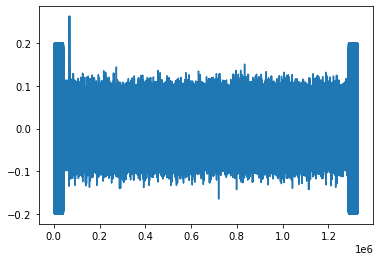

In [5]:
# Generate the data OFDM frames
data_frames, underfill, carrier_indices, pilot_values, bits_tran = test.data_add_random_pilots(test, testfile)
data_frames_len = len(data_frames)
print("Total length of the signal is:", data_frames_len)

# Combine to get the overall tx signals
tx_signal = test.tx_waveform_data_pilot(test, known_frames, chirp, data_frames)
plt.plot(tx_signal)
sf.write('transmit.wav', tx_signal, test.fs)

## Record and load the record file 

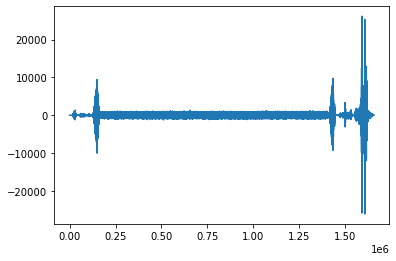

In [14]:
rx_signal = test.real_channel_response_file(test, "sound_files/Rec23.m4a")
plt.plot(rx_signal)

## Use matched filter to determine the chirp location

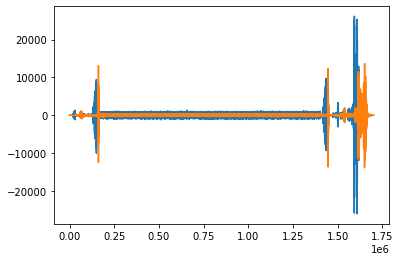

In [15]:
convolution, peak_index1, peak_index2 = test.matched_filter_double(test, rx_signal, inv_chirp)
plt.plot(rx_signal, label='channel op')
plt.plot(convolution/100, label='convolution')
plt.show()

## Measure the channel response with manual selected offset:

In [16]:
split_frame, avg_frame, start_refined = test.process_transmission_pilot(test, rx_signal, peak_index1, offset=20)

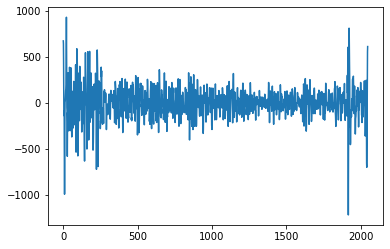

In [17]:
channel_freq_response, channel_imp_response = test.estimate_channel_response_pilot(test, avg_frame, known_frame)
plt.plot(channel_imp_response)

## Retrieve the transmitted informations

1. Manually select the offset 

In [18]:
data_begin = peak_index1 + len(known_frames) + test.gap # include gap

rx_data_full = rx_signal[data_begin:data_begin+len(data_frames)]
rx_data_frames = np.split(rx_data_full, len(rx_data_full)/(test.N+test.prefix_no))

rx_just_data_corrected, rx_just_pilots_corrected, bits_rec = test.data_remove_random_pilots_correct_phase(test, rx_data_frames, carrier_indices, channel_freq_response,  pilot_values, underfill, filename='new.txt')

Last frame
bitstr written to  new.txt


In [19]:
print("BER:", "%.3f" % (error_rate(bits_tran, bits_rec) * 100), "%")

BER: 48.417 %


2. Automatic fine tuning:


In [20]:
best_offset, best_score, bits_rec, best_imp_response = test.fine_tuning_pilot(test, rx_signal, peak_index1, known_frame, carrier_indices, pilot_values, underfill, data_frames_len=data_frames_len, find_range=30, offset=0, filename="test2.png")

Last frame
bitstr written to  test2.png


In [21]:
print("Best Offset:", best_offset)
print("Best Impulse Score:", best_score)
print("BER:", "%.3f" % (error_rate(bits_tran, bits_rec) * 100), "%")

Best Offset: 28
Best Impulse Score: 2.72884845237911
BER: 33.471 %


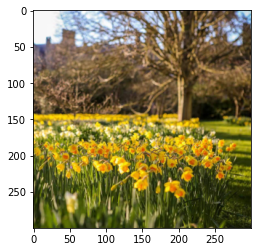

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('test_files/test.png')
imgplot = plt.imshow(img)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('test1.png')
imgplot = plt.imshow(img)

SyntaxError: broken PNG file (bad header checksum in b'PLTE') (<string>)

In [24]:
from osgeo import gdal
import matplotlib.pyplot as plt
  
  
dataset = gdal.Open(r'land_shallow_topo_2048.tif')

ImportError: cannot import name 'gdal' from 'osgeo' (C:\Users\H1937\anaconda3\lib\site-packages\osgeo\__init__.py)